# Recommendations with IBM

In this notebook, we are using real data from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [107]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from srctests import project_tests as t

%matplotlib inline

df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [108]:
# I am using the '0.25.1' pandas version. Pay attention as there are functions which were new in 0.24 (such as the to_numpy())
pd.__version__

'0.25.1'

In [109]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


***Observations:***:
* `df` contains 3 elements:
    * an `id` which is a numeric
    * a `title`, short text (string) describing the article?
    * `email`, string which seems to be a hash value of user's email
* `df_content` contains 5 elements:
    * `doc_body`: a string content (note the "\r\n") that might be things to remove
    * `doc_description`: string value, (short?) description of the content
    * `doc_full_name`: another string value that contains the full name of a document. Perhaps we will need to check whether it is related or not with the `title` from the other dataframe
    * `doc_status`: string value, I guess with the name that is describes the status of the article (is it currently 'Live', meaning 'published' or not?). I will need to check how many different values are possible. Seems to be a good candidate for dummy variable
    * `article_id`: a numeric value, will check if it allows us to merge with the other dataframe on this key.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
Let's start with classic discovery approach.

In [110]:
# Start by counting number of elements in each dataframe
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [111]:
# More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


**Note:** there are missing values in the `email` column! (but very few: only 17)

In [112]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


**Note:** there are missing values in the `doc_body` and `doc_description` columns! (but very few: respectively 14 and 3)

In [113]:
# How many unique values for article_id in both datasets?
print("In df, there are {} unique values for article_id".format(df.article_id.nunique()))
print("In df_content, there are {} unique values for article_id".format(df_content.article_id.nunique()))

In df, there are 714 unique values for article_id
In df_content, there are 1051 unique values for article_id


***Observations:***
* With 1051 unique values in df_content, it seems **we have few duplicates** that we will need to handle later one way or another
* With only 714 unique values for `article_id`, it seems that **not all articles have an interaction with a user** (assumed that we could merge both datasets)

In [114]:
# If email is a hash value, there should have duplicates, meaning that same user had interactions with several articles
df.email.nunique()

5148

In [115]:
# And what about the 'doc_status' column in df_content?
df_content.doc_status.value_counts()

Live    1056
Name: doc_status, dtype: int64

There is only one value, which is _"Live"_ and it is set for all rows so **we can safely drop this `doc_status` column later** as it does not bring any additional information.

---

### 1.1. Distribution of how many articles a user interacts with in the dataset

In [116]:
df.groupby('email').article_id.count().sort_values(ascending=False)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
efdb4c363358224cd99d45053e2dbddf659e25ce      1
3fac88958dc7903b380743597f44a79cf76ea128      1
9c4b5dda1282c94128a7dc778951a313cce8055b      1
3fbe4978a20ee5ddc07648f2762b808ea18cedd1      1
6755c5d49a97e785583f65a92f72bc09459905a9      1
Name: article_id, Length: 5148, dtype: int64

2 users have a lot of interactions (364 and 363) but the third one has less than 200 interactions and we can guess by looking at the tail that a lot of users only interacted once. Let's see exactly how many:

In [117]:
(df.groupby('email').article_id.count() == 1).sum()

1416

C:\Users\David\AppData\Local\Continuum\miniconda3\envs\udadsnd-p5\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


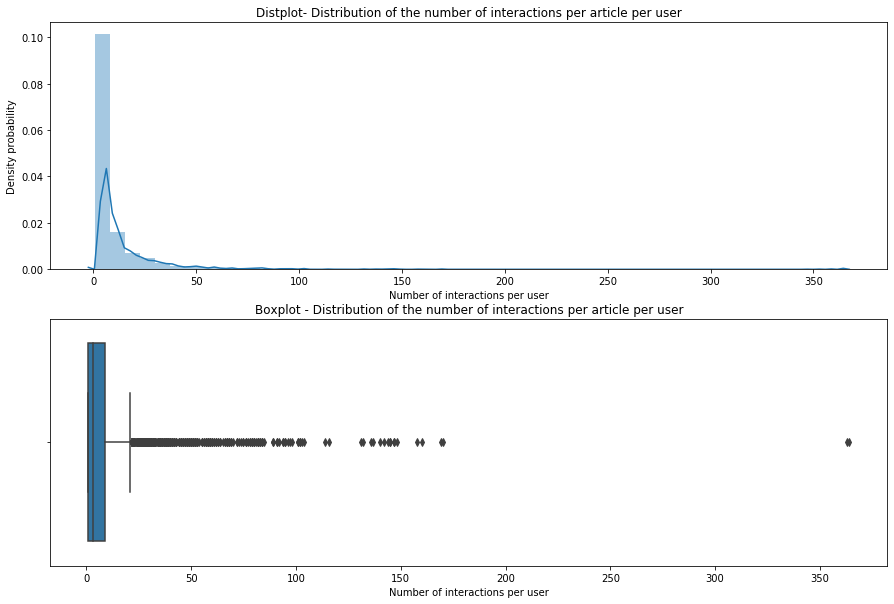

In [118]:
# Let's plot the distribution of the number of interactions per user per article
figure, axis = plt.subplots(2, 1, figsize=(15, 10))
axis[0].set_title("Distplot- Distribution of the number of interactions per article per user")
axis[1].set_title("Boxplot - Distribution of the number of interactions per article per user")
sns.distplot(df.groupby('email').article_id.count(), ax=axis[0])
sns.boxplot(df.groupby('email').article_id.count(), ax=axis[1])
axis[0].set_xlabel("Number of interactions per user")
axis[0].set_ylabel("Density probability")
axis[1].set_xlabel("Number of interactions per user")
plt.show()

As we can see in both graphs above, **a lot of users had a very low rate of interaction with articles**, the main part of them interacted only once or twice.  
This can be seen in the first graph with the probability density which is at its highest value for very low numbers of interactions.  
The boxplot confirms this:
* 1st interquartile is around 1
* 50% of the number of interactions seems to be in the range 1 to 10 approximately
* we can see outliers with small dots

Let's see the share for one or two interactions:

In [119]:
print("{:.2f}% of the users have interacted only once".format(100*(df.groupby('email').article_id.count() == 1).sum()/df.email.nunique()))
print("{:.2f}% of the users have interacted only twice".format(100*(df.groupby('email').article_id.count() == 2).sum()/df.email.nunique()))

27.51% of the users have interacted only once
13.48% of the users have interacted only twice


**Note:** more than 33% of the users interacted at most with 2 articles only. 

In [120]:
# Let's display the interquartile values
df.groupby('email').article_id.count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [121]:
# KEEP TRACK ON SOME VALUES
# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.groupby('email').article_id.count().median()
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df.groupby('email').article_id.count().max()

### 1.2. Duplicates exploration and removal
We have seen earlier that there are few duplicates for `article_id` in the `df_content` dataframe. Let's see what they are and what we can do about that.

In [122]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [123]:
# Display all elements where article_id have duplicates and sort them by article_id so it is easier to compare
df_content[df_content['article_id'].isin(df_content[df_content.duplicated(subset=['article_id'])].article_id)].sort_values(by=['article_id'])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


**Note:** we can see that `doc_body`, `doc_full_name` and `doc_description` columns have sometimes exactly the same content but they are never all the same for a pair of duplicates, there is always at least one column that changes from one article to another. 

In [124]:
# Remove any rows that have the same article_id - only keep the first
nb_dups= df_content[df_content.duplicated(subset=['article_id'])].shape[0]
nb_rows_before = df_content.shape[0]
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)
nb_rows_after = df_content.shape[0]
assert nb_rows_after == nb_rows_before - nb_dups

### 1.3. Some other interesting statistics
Here we will look for:
* **a.** The number of unique articles that have an interaction with a user.  
* **b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
* **c.** The number of unique users in the dataset. (excluding null values) <br>
* **d.** The number of user-article interactions in the dataset.

In [125]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()

# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()

# The number of unique users
unique_users = df.email.nunique()

# The number of user-article interactions
user_article_interactions = df.shape[0]

### 1.4. Finding the most viewed `article_id` and how often it was viewed
***Note from the project team:*** _"after talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below)."_

In [126]:
top_article = df.groupby('article_id').email.count().sort_values(ascending=False).reset_index()[:1]
top_article

,article_id,email
0,1429.0,937


In [127]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = top_article.article_id[0].astype(str)

# The most viewed article in the dataset was viewed how many times?
max_views = top_article.email[0]

### 1.5. `email` column transformation

In [128]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### 1.6. Compare our figures with solution

In [129]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

### Functions to return the **n** top articles ordered with most interactions as the top.

In [130]:
def get_top_n_articles(n, df=df):
    '''
    Return a subset of the given dataframe with n best articles
    :param n: (int) number of top articles to return
    :param df: (pandas DataFrame) the dataframe to filter
    :return: (pandas DataFrame) a subset of the original DataFrame, sorted by best articles descending
    '''
    return df.groupby(['article_id', 'title']).user_id.count().sort_values(ascending=False).reset_index()[:n]

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    # Return the top article titles from df (not df_content)
    return list(get_top_n_articles(n, df).title)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    '''
    # Return the top article ids
    return list(get_top_n_articles(n, df).article_id) 

In [131]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [132]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>
### 3.1. Reformat the `df` dataframe to be shaped with users as the rows and articles as the columns

Here are the rules to follow:
* Each **user** should only appear in each **row** once.
* Each **article** should only show up in one **column**.  
* **If a user has interacted with an article, then we place a 1 where the user-row meets for that article-column**. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  
* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [133]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # ['title'].count() will put some 1's when there is a interaction but NaN elsewhere so we need to replace NaN by 0's
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)
    # But that's not all as one user may have interacted more than once with the same article so we need to maximize at 1
    user_item = user_item.applymap(lambda x: 1 if x > 0.0 else 0)
    return user_item

user_item = create_user_item_matrix(df)

In [134]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


### 3.2. Find similar users
The function below takes a `user_id` and provide an ordered list of the most similar users to that user (from most similar to least similar).  
The returned result does not (obviously) contains the provided user_id, as we know that each user is similar to him/herself.  
Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [135]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users
    '''
    all_users_id = list(user_item.index)
    similarity_memo = {}
    
    # compute similarity of each user to the provided user
    for uid in all_users_id:
        similarity_memo[uid] = np.dot(user_item.loc[user_id], user_item.loc[uid])

    # sort by similarity -> order the dict by value in reverse order
    similarity_memo_sorted = {k: v for k, v in sorted(similarity_memo.items(), key=lambda x: x[1], reverse=True)}

    # create list of just the ids
    most_similar_users = list(similarity_memo_sorted.keys())
   
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users

In [136]:
# Check the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


### 3.3. Recommend articles to users based on users similarity
We now have a function that provides the most similar users to each user so we can use it to find articles to recommend to all users based on their similarity with other users.

In [137]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    return set(list(df[df['article_id'].isin(article_ids)]['title']))


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # np.where(user_item.query('user_id == 1') > 0) returns 2 arrays: 
    #     - first one is row indices (in our case always = 0)
    #     - second one is column indices  <-- we are interested in getting this one only!
    # Then just filter with list comprehension to retrieve column names based on columns indices where condition is True
    article_ids = [str(user_item.columns[i]) for i in np.where(user_item.query('user_id ==  @user_id') > 0)[1]]
    
    # Use our previous function to retrieve names based on those ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    already_seen = get_user_articles(user_id, user_item=user_item)[0]
    
    # Recommended articles will go in this array
    rec_article_ids = np.array([])
    
    for sim_user in similar_users:
        sim_user_seen = get_user_articles(sim_user)[0]
        
        # Get recommendations for this pair (user,similar_user) filtering already seen articles
        new_recs = np.setdiff1d(sim_user_seen, already_seen, assume_unique=True)
        # Update recs with new recs
        rec_article_ids = np.unique(np.concatenate([new_recs, rec_article_ids], axis=0))
        
        # Stop as soon as we have found enough articles to recommend
        if len(rec_article_ids) > m-1:
            # We decide to just truncate at the maximum elements no matter anything else
            rec_article_ids = rec_article_ids[:m]
            break
    
    # Use our previous function to retrieve names based on those ids
    rec_article_names = get_article_names(rec_article_ids)
    
    return rec_article_names

In [138]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [139]:
# Check that recommendations are well limited to m (in our case 10)
len(user_user_recs(20))

10

### 3.4. Improve consistency of the `user_user_recs` function
* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function you wrote earlier.

In [140]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    all_users_id = list(user_item.index)
    # remove the own user's id
    all_users_id.remove(user_id)
    
    neighbors_df = pd.DataFrame(columns=['similar_user_id', 'similarity', 'interactions_count'])
    similarity_memo = []
    n_seen_memo = []
    
    # compute similarity of each user to the provided user + count how many unique interactions with articles
    for uid in all_users_id:
        similarity_memo.append(np.dot(user_item.loc[user_id], user_item.loc[uid]))
        n_seen_memo.append(df[df['user_id'] == uid].article_id.nunique())
    
    neighbors_df['similar_user_id'] = all_users_id
    neighbors_df['similarity'] = similarity_memo
    neighbors_df['interactions_count'] = n_seen_memo
    
    # Order by highest similarity first then number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'interactions_count'], ascending=False)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions before choosing those with fewer article interactions.
    * Choose articles with the most total interactions before choosing those with fewer total interactions.
    '''
    similar_users = list(get_top_sorted_users(user_id).similar_user_id)
    already_seen = get_user_articles(user_id, user_item=user_item)[0]
    
    # Recommended articles will go in this array
    rec_article_ids = np.array([])
    
    for sim_user in similar_users:
        sim_user_seen = get_user_articles(sim_user)[0]
        
        # Get recommendations for this pair (user,similar_user) filtering already seen articles
        new_recs = np.setdiff1d(sim_user_seen, already_seen, assume_unique=True)
        # Update recs with new recs
        rec_article_ids = np.unique(np.concatenate([new_recs, rec_article_ids], axis=0))
        
        # Stop as soon as we have found enough articles to recommend
        if len(rec_article_ids) > m-1:
            df_filter = df[df['article_id'].isin(rec_article_ids)]
            # Keep articles with most interactions
            rec_article_ids = get_top_article_ids(m, df_filter)
            break
    
    # Use our previous function to retrieve names based on those ids
    rec_article_names = get_article_names(rec_article_ids)
    
    return rec_article_ids, rec_article_names

In [141]:
# Check output
get_top_sorted_users(1)

,similar_user_id,similarity,interactions_count
3931,3933,35,35
21,23,17,135
3780,3782,17,135
201,203,15,96
4457,4459,15,96
...,...,...,...
5139,5141,0,1
5142,5144,0,1
5145,5147,0,1
5146,5148,0,1


In [142]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1314.0, 1293.0, 1162.0, 1271.0, 43.0, 1351.0, 1368.0, 1305.0]

The top 10 recommendations for user 20 are the following article names:
{'healthcare python streaming application demo', 'putting a human face on machine learning', 'use deep learning for image classification', 'deep learning with tensorflow course by big data university', 'customer demographics and sales', 'model bike sharing data with spss', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'insights from new york car accident reports', 'gosales transactions for naive bayes model'}


### 3.5. Compare our figures with solution

In [143]:
# Find the user that is most similar to user 1 
user1_most_sim = find_similar_users(1, user_item)[0]

# Find the 10th most similar user to user 131
user131_10th_sim = find_similar_users(131, user_item)[9]

In [144]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


### 3.6. What should we do with a new user?
If we were given a new user, which of the above functions would you be able to use to make recommendations?  
Can you think of a better way we might make recommendations?

**ANSWER:** as we have no information about the user (no interaction so we cannot find most similar users among our population) **we have no other choice to recommend this new user the top n articles all the other users interacted with**. We have then more odds that this new user will like them (as many others did) but there is no warranty.  
And perhaps that those articles are the ones with most interactions because as they are shown to new users, those ones interact with them and so their number of views keeps increasing. Though, this would be less and less true as the users database grows and more of them interact with more articles.

We could ask few questions to the user to get more information about topics he is interested in and then propose articles where content is more related to information he gave us (mix of knowledge-based and content-based recommendation).

### 3.7. Provide the top 10 recommended articles to a new user

In [145]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set(get_top_article_ids(10))

In [146]:
assert set(new_user_recs) == set([1314.0, 1429.0, 1293.0, 1427.0, 1162.0, 1364.0, 1304.0, 1170.0, 1431.0, 1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>
Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

### 4.1. Create a content based recommender
For sure we will have to deal with text columns (`doc_body`, `doc_description` and `doc_full_name`) in `df_content` dataset.   In order to reduce as much as possible our vocabulary size we must remove punctuation, stop_words, most frequent words and also lemmatize the text (so that for example 'changing', 'changed' and 'changes' all go under 'change').  
We could also decide to focus on a specific part-of-speech (for example keep only NOUNS, VERBS, ADJECTIVES).

For all this NLP task I will use the **[spacy](https://spacy.io/)** package as I am pretty familiar with it.

But first things first, let's import spacy and load a model:

In [147]:
import spacy
# Dependency labels, Name Entity Recognition and Text Categorization are not need for our specific usage
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

We will also need a lemmatization function:

In [148]:
def lemmatize_text(x, nlp, pos=[None]):
    """
    Lemmatize text from a string.
    :param x: (string) the text we want to lemmatize
    :param nlp: (spacy object) spacy NLP loaded model to user for tokenization/lemmatization
    :param pos: (list) filter on listed part-of-speech tagging
    :return: (string) string containing the lemmatized text.
    """
    doc = nlp.tokenizer(x.lower()) if pos == [None] else nlp(x.lower())
    lemma_txt = [token.lemma_ for token in doc if not 
              token.is_punct |
              token.is_space |
              token.is_stop |
              token.is_digit |
              token.is_quote |
              token.is_bracket |
              token.is_currency |
              token.like_url |
              token.like_email |
              ((token.pos_ not in pos) and (pos != [None]))]
    lemma_txt = ' '.join(lemma_txt)
    return lemma_txt

And now, let's explore the text columns content:

In [149]:
df_content.iloc[0].doc_body

"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next video is starting stop 1. Loading...\r\n\r\nWatch Queue Queue __count__/__total__ Find out why CloseDEMO: DETECT MALFUNCTIONING IOT SENSORS WITH STREAMING ANALYTICS\r\nIBM AnalyticsLoading...\r\n\r\nUnsubscribe from IBM Analytics? Cancel UnsubscribeWorking...\r\n\r\nSubscribe Subscribed Unsubscribe 26KLoading...\r\n\r\nLoading...\r\n\r\nWorking...\r\n\r\nAdd toWANT TO WATCH THIS AGAIN LATER?\r\nSign in to add this video to a playlist. Sign in Share More * ReportNEED TO REPORT THE VIDEO?\r\n   Sign in to report inappropriate content. Sign in\r\n * Transcript\r\n * Statistics\r\n * Add translations\r\n\r\n175 views 6LIKE THIS VIDEO?\r\nSign in to make your opinion count. Sign in 7 0DON'T LIKE THIS VIDEO?\r\nSign in to make your opinion count. Sign in 1Loading...\r\n\r\nLoading...\r\n\r\nTRANSCR

***Note:*** Ouch! This is ugly! There are a lot of "\r\n" values, name of people with time or duration. This is not really useful if we keep it like that.

In [150]:
df_content.iloc[0].doc_description

'Detect bad readings in real time using Python and Streaming Analytics.'

In [151]:
df_content.iloc[0].doc_full_name

'Detect Malfunctioning IoT Sensors with Streaming Analytics'

***Note:*** content in `doc_description` and `doc_full_name` column seems to be 'clean' but there are few words in comparison to what is available in `doc_body`. If we cannot find a way to clean what is in `doc_body` we will just keep those 2 columns.  
But before that, let's try our function to see how it goes:

In [152]:
lemmatize_text(df_content.iloc[0].doc_body, nlp, pos=['NOUN', 'VERB', 'ADJ'])

'skip navigation sign searchload close undo closethis video unavailable watch queue queue watch queue queue remove disconnect video start stop loading watch queue queue count__/__total find closedemo detect malfunction iot sensor stream analytic ibm analyticsload unsubscribe ibm analytic cancel unsubscribeworking subscribe subscribed unsubscribe 26kload loading work add towant watch sign add video playlist sign share reportneed report video sign report inappropriate content sign transcript statistic add translation view video sign opinion count sign video sign opinion count sign loading transcript interactive transcript loaded.load loading rating available video rent feature available try publish video demonstrate streaming analytic application write python run ibm data science experience result analysis display map notebook demonstrate video available try visit streamsdev article tip stream python api developer guide stream analytic python course category science technology license st

***Note***: not too bad! The function did not remove duplicates, we can see for example several times the word _database_ or _cassandra_. It is OK, for the moment I will keep it like that as I still do not know exactly what I will do, perhaps a CountVectorizer or even a TF-IDF so I need to keep duplicates.

Now, let's gather all text columns into a single one then perform lemmatization over the whole `df_content` dataset:

In [153]:
df_content['full_text'] = df_content['doc_body'] + df_content['doc_description'] + df_content['doc_full_name']
df_lemma = df_content[['article_id', 'full_text']]
df_lemma

,article_id,full_text
0,0,Skip navigation Sign in SearchLoading...\r\n\r...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA..."
4,4,Skip navigation Sign in SearchLoading...\r\n\r...
...,...,...
1051,1046,PouchDB-find is a new API and syntax that allo...
1052,1047,We compare discriminative and generative learn...
1053,1048,"Essays about data, building products and boots..."
1054,1049,NaN


***Note:*** it seems there are some NaN values! For example the article_id 1049.

In [154]:
df_lemma[df_lemma['article_id'] == 1049].full_text

1054    NaN
Name: full_text, dtype: object

In [155]:
df_lemma = df_lemma.dropna()
df_lemma

,article_id,full_text
0,0,Skip navigation Sign in SearchLoading...\r\n\r...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA..."
4,4,Skip navigation Sign in SearchLoading...\r\n\r...
...,...,...
1050,1045,lA SPEED GUIDE TO REDIS LUA SCRIPTING\r\nShare...
1051,1046,PouchDB-find is a new API and syntax that allo...
1052,1047,We compare discriminative and generative learn...
1053,1048,"Essays about data, building products and boots..."


OK, now we can apply the lemmatization process:

In [156]:
df_lemma['lemmas'] = df_lemma['full_text'].apply(lambda x: lemmatize_text(x, nlp, pos=['NOUN', 'VERB', 'ADJ']))
df_lemma

C:\Users\David\AppData\Local\Continuum\miniconda3\envs\udadsnd-p5\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,article_id,full_text,lemmas
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,free hunch navigation communicate datum scienc...
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,☰ login sign learning path course course partn...
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",datalayer high throughput low latency scale bo...
4,4,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
...,...,...,...
1050,1045,lA SPEED GUIDE TO REDIS LUA SCRIPTING\r\nShare...,la speed guide redis lua script share twitter ...
1051,1046,PouchDB-find is a new API and syntax that allo...,pouchdb find new api syntax allow simple way q...
1052,1047,We compare discriminative and generative learn...,compare discriminative generative learning typ...
1053,1048,"Essays about data, building products and boots...",essay datum building product bootstrapping bus...


#### Build articles-to-words matrix
***Approach***: I will give a try to a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) so that it will help me to build a big bag-of-words matrix where rows are the article_id and each column represents a word available in the vocabulary (in our case, whole text for all articles). Here are some parameters that will be used to tune the CountVectorizer and why they were chosen: 
* With such a number of articles with sometimes a lot of text, it might quick lead to a huge vocabulary size, we will control this with the `max_features` parameter (as per sklearn documentation: _"build a vocabulary that only consider the top max_features ordered by term frequency across the corpus"_ ). To find the 'good' value I first ran without this parameter and displayed the vocabulary size and it was 30597. So 20000 is around 66%, let's try with that. 
* In order to remove also words with too high frequency, we can use the `max_df` parameter (as per sklearn documentation: _"When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)"_ )
* We can also specify that we want to remove common words from english vocabulary (even if we did stop words removal with spacy, it will not hurt).
* As my plan is to perform dot product between 2 articles, I need to put the `binary` parameter to True so that even if a word appears more than once, it will be set to 1. It is just an intuition but I am afraid that sometimes one word could appear 10 times in one document and only once in another, it will automatically add 10 in the dot product computation. With only 0's and 1's we avoid that.

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.5, binary=True, max_features=20000)
# Build the corpus by taking only lemmas as a numpy array
corpus = df_lemma['lemmas'].to_numpy()
X = vectorizer.fit_transform(corpus)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [158]:
# If it works it should display the same number of rows as in the dataframe and 20000 columns (= max_features parameter)
X.shape

(1034, 20000)

OK, fine! Let's explore the `stop_words_` attribute to ensure we did not remove too many 'important' words. As per sklearn documentation, this will show all words that were removed because they either:
* occurred in too many documents (`max_df`)
* were cut off by feature selection (`max_features`)

In [159]:
vectorizer.stop_words_

{'firstthis',
 'bothell',
 'anmmorpg',
 'mong',
 'geomerylike',
 '4342711412228',
 'mongowrapper',
 'misunderstanding',
 'anadditional',
 'mahmoud',
 'digitalglynn',
 'elasticsearchwrapper',
 'embeddings',
 'lecunthe',
 'athleticism',
 'futurewe',
 'mab',
 'jamersonof',
 'drmxtx',
 '13673',
 'goossen',
 'action_dim',
 'epochresults_long',
 'cdf',
 'crunchbase_url',
 'forecastthe',
 'hasalway',
 'maxiter',
 'addend',
 'innings',
 'borderline',
 'haproxy429',
 '_size',
 'defaulter',
 'df_num_tweets_and_sentiment_over_time',
 'hackability',
 'cb_description',
 'htmllist',
 'dyoptions',
 'ltvs',
 'javasript',
 'iterat',
 'automl',
 'datum',
 'dashboardlocate',
 'keystructure',
 'feedempirical',
 'initiatives',
 'norbertomouth',
 'grandpa',
 '20return',
 'accordion',
 '5900b01b2ce12a2383328fa2',
 'egxxx',
 '68',
 'kearn',
 'electric_car',
 'existential',
 'mysqldon',
 'autocomplete_enable',
 'datenow',
 'etiquette',
 'ioffe',
 'dmlstatement',
 'ax0',
 'matirx',
 'markdownkeyboard',
 'intert

It seems ok and we removed words that were not well-formed, such as 'differentcode' without the whitespace for example. Now let's see if our cut were not too high with some words that we would like to keep:

In [160]:
words_to_keep = ['xgboost', 'scikit-learn', 'python']
[x in vectorizer.stop_words_ for x in words_to_keep]

[False, False, False]

**That's good, those words were not removed!**

In [161]:
articles_to_words = pd.DataFrame(data=X.toarray(), index=df_lemma.article_id, columns=vectorizer.get_feature_names())
articles_to_words

,00,000,0000,0001,000z,001,00leave,01,0174532925199433,01t00,...,中文,安田万智子,您好,日本語,简体,한국어,ﬁgure,ﬁnd,ﬁnite,ﬁx
article_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Nice! We now have a matrix with 0's and 1's where rows are the article_id and columns all the words kept by our CountVectorizer. Sounds like user-item matrix no?  

#### Find similar articles based on their content
To compute similarity between articles, we will apply the same technique: dot product between both.

In [162]:
def find_similar_articles(article_id, articles_to_words=articles_to_words):
    '''
    INPUT:
    article_id - (int) a article_id
    articles_to_words - (pandas dataframe) matrix of articles by words: 
                1's when an article contains the word, 0 otherwise
    
    OUTPUT:
    similar_articles - (list) an ordered list where the closest articles (largest dot product articles) are listed first
    
    Description:
    Computes the similarity of every pair of articles based on the dot product
    Returns an ordered list of most similar articles
    '''
    all_articles_id = list(articles_to_words.index)
    similarity_memo = {}
    
    # compute similarity of each user to the provided user
    for aid in all_articles_id:
        similarity_memo[aid] = np.dot(articles_to_words.loc[article_id], articles_to_words.loc[aid])

    # sort by similarity -> order the dict by value in reverse order
    similarity_memo_sorted = {k: v for k, v in sorted(similarity_memo.items(), key=lambda x: x[1], reverse=True)}

    # create list of just the ids
    most_similar_articles = list(similarity_memo_sorted.keys())
   
    # remove the own article's id
    most_similar_articles.remove(article_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_articles

In [163]:
# Check it
find_similar_articles(0)[:5]

[925, 182, 443, 626, 763]

In [164]:
df_content[df_content['article_id'].isin([0, 925, 182, 443, 626, 763])]

,doc_body,doc_description,doc_full_name,doc_status,article_id,full_text
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Skip navigation Sign in SearchLoading...\r\n\r...
182,Skip navigation Sign in SearchLoading...\r\n\r...,This video is a quick tour of the RStudio Inte...,Overview of RStudio IDE in DSX,Live,182,Skip navigation Sign in SearchLoading...\r\n\r...
444,Try out a fresh look for YouTube. Learn more ....,This video shows you how to load Db2 Warehouse...,Load Db2 Warehouse on Cloud data with Apache S...,Live,443,Try out a fresh look for YouTube. Learn more ....
627,Skip navigation Sign in SearchLoading...\r\n\r...,This video shows you how to connect to an IBM ...,Analyze Db2 Warehouse on Cloud data in RStudio...,Live,626,Skip navigation Sign in SearchLoading...\r\n\r...
766,Skip navigation Sign in SearchLoading...\r\n\r...,This video shows you how to upload CSV data fo...,Load data into RStudio for analysis in DSX,Live,763,Skip navigation Sign in SearchLoading...\r\n\r...
928,Skip navigation Sign in SearchLoading...\r\n\r...,This video shows you how to use the Spark SQL ...,Build SQL queries with Apache Spark in DSX,Live,925,Skip navigation Sign in SearchLoading...\r\n\r...


In [165]:
# With the lemmas it will be more understandable why those articles are similar
df_lemma[df_lemma['article_id'].isin([0, 925, 182, 443, 626, 763])]

,article_id,full_text,lemmas
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
182,182,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
444,443,Try out a fresh look for YouTube. Learn more ....,try fresh look youtube learn close skip naviga...
627,626,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
766,763,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...
928,925,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...


***Observation:*** ouch! It seems that this content is related to video or something like that and then there is kind of a pattern in the content, that's why the most similar articles are probably not based on important words but just due to the fact that all of them are videos. It would take more time to analyze more deeply this issue and how to build a good workaround.  
For the moment I will manually add those words to spacy stop_words and will see. There are also some words that are just integers, we can remove those as well.  
Let's give another try:

In [166]:
# Display the columns
list(articles_to_words.columns)

['00',
 '000',
 '0000',
 '0001',
 '000z',
 '001',
 '00leave',
 '01',
 '0174532925199433',
 '01t00',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '08t21',
 '0don',
 '0f',
 '0n',
 '0px',
 '0th',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '10001',
 '100k',
 '101',
 '102',
 '10287',
 '10302',
 '10k',
 '10th',
 '11',
 '110',
 '111',
 '116',
 '11th',
 '12',
 '122',
 '123',
 '1234567',
 '125',
 '127',
 '128',
 '12th',
 '13',
 '13th',
 '14',
 '143',
 '144',
 '1489025722',
 '1489026108',
 '14th',
 '15',
 '15234',
 '15kload',
 '15th',
 '16',
 '16th',
 '17',
 '17072',
 '17kload',
 '17th',
 '18',
 '180',
 '1800',
 '18177',
 '18kload',
 '18th',
 '19',
 '1950',
 '1970',
 '1980',
 '1990',
 '19th',
 '1e',
 '1f',
 '1j6uprt',
 '1k',
 '1l1',
 '1naoodr',
 '1nbtivd',
 '1nkezoy',
 '1px',
 '1qhfjpw',
 '1s89mln',
 '1st',
 '1udqev4',
 '20',
 '200',
 '2000',
 '201',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2015build',
 '2015see',
 '2015watch',
 '2016',
 '2016mak',
 '2016power',
 '2017',
 

***Observations:***
* I think it is safe to remove all columns (so words) that start with a digit or underscore ('_').
* We could also filter on words length (for example 2)

Add some new stop words:  
***Note:*** the list below has been built with several runs of trial/error analysis in order to add new words to remove.

In [167]:
to_remove = 'skip navigation sign searchloading close undo closethis video unavailable watch queue queue watch queue queue'
to_remove += ' remove disconnect video start starting stop loading watch queue queue count__/__total find closedemo'
to_remove += ' youtube term privacy policy safety send feedback add lateradd playlist autoplay duration'
to_remove += ' report inappropriate content twitter share facebook google+'
to_remove += ' count__/__total__try closedata ibm analytic analytics analyticsloading unsubscribe unsubscribeworking subscribe subscribed later reportneed transcript interactive loaded.loading streaming'
to_remove += ' helploading lessloading playlists analytics.detect views suggestions english location united states restricted mode history press copyright'

***Observation:*** it should not hurt too much if we remove all those words unless perhaps the word `video` for 2 reasons:
* it could be related to kind of computer vision topic
* if you have interacted with a video perhaps it means you are more willing to watch videos than reading text

In [168]:
additional_stop_words = set(to_remove.split())
additional_stop_words.remove('video')

In [169]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
for stop_word in additional_stop_words:
    nlp.vocab[stop_word].is_stop = True

And let's build a new version of the lemmatization function:

In [170]:
def lemmatize_text_v2(x, nlp, pos=[None]):
    """
    Lemmatize text from a string.
    :param x: (string) the text we want to lemmatize
    :param nlp: (spacy object) spacy NLP loaded model to user for tokenization/lemmatization
    :param pos: (list) filter on listed part-of-speech tagging
    :return: (string) string containing the lemmatized text.
    """
    doc = nlp.tokenizer(x.lower()) if pos == [None] else nlp(x.lower())
    lemma_txt = [token.lemma_ for token in doc if not 
              token.is_punct |
              token.is_space |
              token.is_stop |
              token.is_digit |
              token.is_quote |
              token.is_bracket |
              token.is_currency |
              token.like_url |
              token.like_email |
              token.like_num |
              (re.match("^[0-9_]", token.lemma_) is not None) |
              ((token.pos_ not in pos) and (pos != [None]))]
    lemma_txt = ' '.join(lemma_txt)
    return lemma_txt

Let's start over the process:
* Add new feature wich will be the result of the lemmatization with new stop words and some other words removal
* Fit a new vectorizer
* Build a new articles-to-words matrix
* Use our already coded function that finds similar articles by giving it this new matrix

In [171]:
df_lemma['lemmas_v2'] = df_lemma['full_text'].apply(lambda x: lemmatize_text_v2(x, nlp, pos=['NOUN', 'VERB', 'ADJ']))
df_lemma

C:\Users\David\AppData\Local\Continuum\miniconda3\envs\udadsnd-p5\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,article_id,full_text,lemmas,lemmas_v2
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...,video video detect malfunction iot sensor canc...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,free hunch navigation communicate datum scienc...,free hunch communicate datum science guide pre...
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,☰ login sign learning path course course partn...,☰ login learning path course course partner co...
3,3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",datalayer high throughput low latency scale bo...,datalayer high throughput low latency scale bo...
4,4,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...,video video science experience analyze restaur...
...,...,...,...,...
1050,1045,lA SPEED GUIDE TO REDIS LUA SCRIPTING\r\nShare...,la speed guide redis lua script share twitter ...,la speed guide redis lua script vote hacker ne...
1051,1046,PouchDB-find is a new API and syntax that allo...,pouchdb find new api syntax allow simple way q...,pouchdb new api syntax allow simple way query ...
1052,1047,We compare discriminative and generative learn...,compare discriminative generative learning typ...,compare discriminative generative learning typ...
1053,1048,"Essays about data, building products and boots...",essay datum building product bootstrapping bus...,essay datum building product bootstrapping bus...


In [172]:
vectorizer_v2 = CountVectorizer(stop_words='english', max_df=0.5, binary=True, max_features=20000)
# Build the corpus by taking only lemmas as a numpy array
corpus_v2 = df_lemma['lemmas_v2'].to_numpy()
X_v2 = vectorizer_v2.fit_transform(corpus_v2)
X_v2.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [173]:
articles_to_words_v2 = pd.DataFrame(data=X_v2.toarray(), index=df_lemma.article_id, columns=vectorizer_v2.get_feature_names())
articles_to_words_v2

,00,000,0001,001,01,0174532925199433,03,04,05,06,...,中文,安田万智子,您好,日本語,简体,한국어,ﬁgure,ﬁnd,ﬁnite,ﬁx
article_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Observation:*** there are still remaining columns that are digits. Why? Let's try to understand with this column name for example: '0174532925199433'

In [174]:
# Find 1 article where it appears
art_to_analyze = articles_to_words_v2['0174532925199433'].sort_values(ascending=False)[:2]
art_to_analyze

article_id
998    1
581    1
Name: 0174532925199433, dtype: int64

In [175]:
df_lemma.loc[df_lemma['article_id'] == 998]['lemmas_v2'].unique()[0]

'geofile postgis raster datum vote hacker news publish dec series dedicate look geographical datum feature use article will look raster datum use shapefile raster perspective map superimpose georeferenc image map be familiar satellite image thermal imagery elevation feature map expose raster datum raster datum help identify change map detail shapefile provide environmental change time lot article will cover surface raster datum provide look raster data gather information raster datum gdal utility import view raster datum postgresql database raster2pgsql superimpose shapefile qgis raster datum raster data collection pixel cell organize row column geospatial information form tile pixel give attribute value define geographic feature assign srid reference coordinate refer georeferenc raster time attribute value add refer band hold actual raster datum example map town break small section tile record information section cell band raster datum time look satellite imagery online map look real 

***Note:*** it is due to that: "unit["degree",0.0174532925199433" ...  
OK, there is still a lot to do to clean this but anyway, I am pretty sure we made progress so let's see what is the result

In [176]:
# Check it
find_similar_articles(0, articles_to_words_v2)[:5]

[482, 139, 656, 1006, 351]

Interesting! It has changed! Remember that previously articles ids were: 925, 182, 443, 626, 763.  
Now it has changed, let's see if it is for the better:

In [177]:
# With the lemmas it will be more understandable why those articles are similar
df_lemma[df_lemma['article_id'].isin([0, 482, 139, 656, 1006, 351])]

,article_id,full_text,lemmas,lemmas_v2
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...,video video detect malfunction iot sensor canc...
139,139,Enterprise Pricing Articles Sign in Free 30-Da...,enterprise pricing article sign free trialdesi...,enterprise pricing article free trialdesign uf...
351,351,developerWorks Premium An all-access pass to b...,developerwork premium access pass build great ...,developerwork premium access pass build great ...
483,482,Toggle navigation * Services\r\n * Demo\r\n * ...,toggle navigation service demo software blog c...,toggle service demo software blog contact cust...
657,656,Homepage Stats and Bots Follow Sign in Get sta...,homepage stat bot follow sign start home data ...,homepage stat bot follow start home data scien...
1011,1006,* Home\r\n * Blog * Business Analytics * SAS\r...,home blog business analytic sa python business...,home blog business sa python business intellig...


***Obervation:*** this is not so easy to say without a deeper analysis but now the similar articles are not the one with same words due to the fact that they were all videos.

#### Find articles related to a given content

In [178]:
words = ['python', 'scikit-learn']
words_vec = vectorizer.transform(words).toarray()
assert len(words_vec[0]) == 20000
assert words_vec.sum() == len(words)

In [179]:
def find_related_articles(words, vectorizer, articles_to_words=articles_to_words):
    '''
    INPUT:
    words - (array) one or more words about a topic
    vectorizer - the sklearn vectorizer object used to fit against the corpus
    articles_to_words - (pandas dataframe) matrix of articles by words: 
                1's when an article contains the word, 0 otherwise
    
    OUTPUT:
    similar_articles - (list) an ordered list where the closest articles (largest dot product articles) are listed first
    
    Description:
    Computes the similarity of given words with articles content based on the dot product
    Returns an ordered list of most 'related' articles
    '''
    all_articles_id = list(articles_to_words.index)
    similarity_memo = {}
    words_vec = vectorizer.transform(words).toarray()[0]
    
    # compute similarity of each user to the provided user
    for aid in all_articles_id:
        similarity_memo[aid] = np.dot(words_vec, articles_to_words.loc[aid])

    # sort by similarity -> order the dict by value in reverse order
    similarity_memo_sorted = {k: v for k, v in sorted(similarity_memo.items(), key=lambda x: x[1], reverse=True)}

    # create list of just the ids
    most_similar_articles = list(similarity_memo_sorted.keys())
    
    # return a list of the users in order from most to least similar
    return most_similar_articles

In [180]:
# Check it
find_related_articles(words, vectorizer)[:5]

[0, 1, 2, 4, 12]

In [181]:
df_content[df_content['article_id'].isin([0, 1, 2, 4, 12])]

,doc_body,doc_description,doc_full_name,doc_status,article_id,full_text
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Skip navigation Sign in SearchLoading...\r\n\r...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,Skip navigation Sign in SearchLoading...\r\n\r...
12,Skip to main content IBM developerWorks / Deve...,This recipe showcases how one can analyze the ...,Timeseries Data Analysis of IoT events by usin...,Live,12,Skip to main content IBM developerWorks / Deve...


In [182]:
df_lemma[df_lemma['article_id'].isin([0, 1, 2, 4, 12])]

,article_id,full_text,lemmas,lemmas_v2
0,0,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...,video video detect malfunction iot sensor canc...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,free hunch navigation communicate datum scienc...,free hunch communicate datum science guide pre...
2,2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,☰ login sign learning path course course partn...,☰ login learning path course course partner co...
4,4,Skip navigation Sign in SearchLoading...\r\n\r...,skip navigation sign searchload close undo clo...,video video science experience analyze restaur...
12,12,Skip to main content IBM developerWorks / Deve...,skip main content ibm developerwork developer ...,main developerwork developer center register t...


### 4.2. How it works?
Let's recap everything:
* The **content-based recommender system used all text columns** available in the `df_content` dataframe.  
* The **text has been lemmatized, stop words were removed** as well as punctuation. Everything was also put into lowercase.
* Then a bag-of-words is built with the **CountVectorizer from sklearn: it takes all words and build a vocabulary** (more than 30000 different words).
* **Vocabulary size is controlled** with some parameters that allows to remove stop words (again) and words that appears too often (so they do not bring a useful information). In the end, the vocabulary size has been limited to 20000 words.
* With the CountVectorizer **we are able to build a matrix full of 0's and 1's where rows are articles ids and 20000 columns**, one from each word in the vocabulary. If value is 1, the word has been seen at least once in the document.
* This articles-2-words matrix allows us to **compute a similarity between 2 articles by using dot product**.
* We are also able to take a list of words as input, use our CountVectorizer to transform it into an array of shape (1, 20000) and then find most similar articles (again with the dot product)

**How could it then be used?**
* If user is totally new and we know nothing about him, there is no magic, we are stucked with the n top articles ranking.
* If user is new but is willing to give us few words representing his topics of interest we could then use those words to find most related articles.
* When user has few interactions, we could use a mix of collaborative filtering and content-based recommendation as for example with only one article read, it is not so obvious to find the "same" user and result might be disappointing. I think it is more relevant to suggest articles that talks about same topic.

### 4.3. 2 scenarios: brand new user and user with one interaction
#### Make recommendations for a brand new user
No magic, we are stucked with the n top articles ranking.

In [183]:
new_user_recs = set(get_top_articles(10))
new_user_recs

{'analyze energy consumption in buildings',
 'apache spark lab, part 1: basic concepts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for logistic regression model',
 'healthcare python streaming application demo',
 'insights from new york car accident reports',
 'predicting churn with the spss random tree algorithm',
 'use deep learning for image classification',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'visualize car data with brunel'}

#### Make recommendations for a user who only has interacted with article id '1427.0'

In [184]:
# First we get the text
article_1427_title = list(df[df['article_id'] == 1427.0].title.unique())[0]
article_1427_title

'use xgboost, scikit-learn & ibm watson machine learning apis'

In [185]:
# Then we use our lemmatization function
article_1427_lemma = lemmatize_text_v2(article_1427_title, nlp, pos=['NOUN', 'ADJ', 'VERB'])
article_1427_lemma

'use xgboost scikit learn watson machine learn'

In [186]:
article_ids_related = find_related_articles([article_1427_lemma], vectorizer_v2, articles_to_words_v2)[:10]
get_article_names(article_ids_related)

{'56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'build a logistic regression model with wml & dsx',
 'dsx: hybrid mode',
 'ensemble learning to improve machine learning results',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage scikit-learn models with core ml',
 'modeling energy usage in new york city',
 'top analytics tools in 2016',
 'using deep learning with keras to predict customer churn',
 'using machine learning to predict value of homes on airbnb'}

***CONCLUSION of the content-based recommender system***  
This is a vey basic approach that takes all the text elements and count all words. We could improve it:
* by adding more stop words and building a strong and powerful vocabulary
* by giving more weight to some words. Here all words have the same weight and we would probably like to give the word 'xgboost' more importance than the word 'home'. TF-IDF could help us by playing with terms frequencies and/or the document frequency in the corpus.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.
### 5.1. Load a previously saved user matrix

In [194]:
user_item_matrix = pd.read_pickle('../srctests/user_item_matrix.p')
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
user_item_matrix.shape

(5149, 714)

In [196]:
user_item_matrix.isna().sum()

article_id
0.0       0
100.0     0
1000.0    0
1004.0    0
1006.0    0
         ..
986.0     0
990.0     0
993.0     0
996.0     0
997.0     0
Length: 714, dtype: int64

### 5.2. Use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix
Perform SVD, and explain why this is different than in the lesson.

In [197]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

Here **we can perform the SVD operation as there is no missing value in the matrix**. Otherwise it would have not been possible. In our case, which is binary 0/1 it is easier than in a "rating" problem as we could arbitrarily decide to replace all NaNs with 0's. So it works!

### 5.3. Choose the number of latent features to use 
Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  
Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

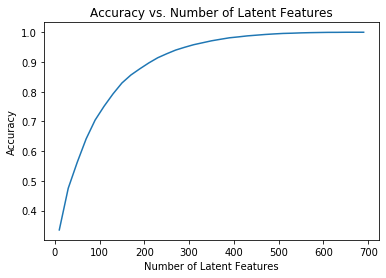

In [198]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### 5.4. Split into train/test
From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  
Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Let's try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:
* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [199]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [200]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = np.unique(df_test.user_id)
    test_arts = np.unique(df_test.article_id)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [201]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [202]:
# How many users are in both datasets?
intersect_count = len(np.intersect1d(list(user_item_train.index), list(user_item_test.index)))
intersect_count

20

In [203]:
# How many due to cold start issue? (in our case, no training data so not even one interaction at all just to start using SVD)
user_item_test.shape[0] - intersect_count

662

In [204]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


### 5.5. Perform SVD on `user_item_train` dataframe
Then we will find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.  
This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [205]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train[user_item_test.columns])
s_train.shape, u_train.shape, vt_train.shape

((574,), (4487, 4487), (574, 574))

In [206]:
# Build the subset to test dataset
common_user_ids_train_test = np.intersect1d(list(user_item_train.index), list(user_item_test.index))
subset_test = user_item_test.loc[common_user_ids_train_test]
common_user_ids_train_test

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

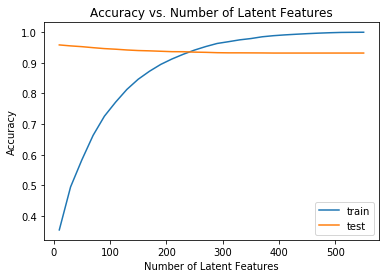

In [207]:
num_latent_feats = np.arange(10,550+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    # Compute error only on a subset wich is available in both train and test
    user_item_est_subset = [user_item_est[i-1] for i in common_user_ids_train_test]
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train[user_item_test.columns], user_item_est)
    diffs_test = np.subtract(subset_test, user_item_est_subset)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err)
    err = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df_train.shape[0], label="train");
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df_test.shape[0], label="test");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc='best');

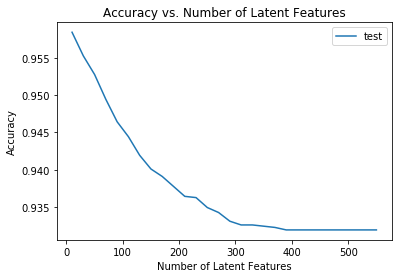

In [208]:
# Focus only on test
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df_test.shape[0], label="test");
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc='best');

In [209]:
# How many interaction per user?
subset_test.sum(axis=1)

user_id
2917     2
3024     7
3093     5
3193     5
3527     1
3532    32
3684     3
3740    55
3777     1
3801    26
3968     8
3989     1
3990     1
3998     8
4002    10
4204     2
4231    16
4274     5
4293    26
4487     4
dtype: int64

In [210]:
# How many interaction overall this subset?
subset_test.sum().sum()

218

### 5.6. Discussion about the results
As we increase the number of features we can see that accuracy on train increases while the one on test is worse!  
It is difficult (and dangerous) to make any decision based on that are there were only 20 users in common between both datasets. It would have been a better approach (perhaps?) to shuffle the `df_content` before splitting to have more chances to get more users in both (or do it manually).  
20 users for 574 articles = 11480 potential interactions. Actually, 218 were to predict to 1 (less than 2%). That is very imbalanced and one 'dummy classifier' always giving 0 would be very accurate. The conclusion is that we cannot say anything with so few data. We need to get more before

#### So what can we do to determine if the recommendations are an improvement to how users currently find articles?
* We could keep a track of our recommendations for the different users and monitor with web-tracking for instance if they actually interacted with our suggestions.  
* More intrusive: we could ask to people if they would like to give feedback about our suggestions (simple voting system online like 'did you like our suggestions?')